In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path = './results/'
sns.set_style("whitegrid")
!ls $path

controv		 max_topics_upvotes  topics_counter	  user_count
hot_topics	 subreddit_count     topics_counter_user  user_max
hot_topics_user  subreddit_max	     topics_updown	  what_time


# 1. Counting subreddit and user counts
We counted how many comments in each subreddit/submitted by each user to get a sense of which subreddits are more important than others, which users are more interactive than others and hence get more in depth insights about those subreddits/users later.

,subreddit,count
0,AskReddit,108
1,funny,40
2,pcmasterrace,34


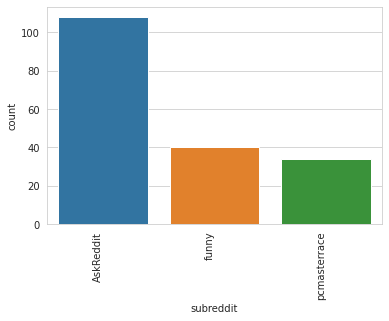

In [164]:
df_sub = pd.read_csv(path+'subreddit_max', sep=' ', header=None, names= ['subreddit','count'])
display(df_sub)
g = sns.barplot(x='subreddit', y='count', data = df_sub)
g.set_xticklabels(g.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right');

,user,count
0,subredditreports,6
1,AutoModerator,3
2,TurtleforAG,3


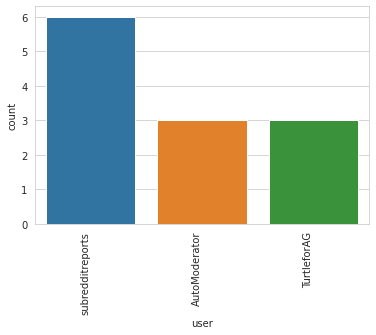

In [165]:
df_usr = pd.read_csv(path+'user_max', sep=' ', header=None, names= ['user','count'])
display(df_usr)
g = sns.barplot(x='user', y='count', data = df_usr)
g.set_xticklabels(g.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right');

# 2. Hot topics
Now we check what are the top mentioned topics in the comments. We only asssumed highest 3 reddits/users. We assumed the most common word in a comment is the topic of the comment. We found that there are multiple words more repeated more than once which is a good sign (after removing the stop words). Here are the results we got.

A noticable thing here is all the top comments are of 1 frequency. That means there is no two comments of the same topic in the same subreddit. I'm not sure if this will hold on the big dataset or not but let's hope it won't.

,count,subreddit,topic
0,1.0,AskReddit,song
1,1.0,AskReddit,sometimes
2,1.0,AskReddit,snack
3,1.0,AskReddit,post
4,1.0,AskReddit,please
5,1.0,AskReddit,playing
6,1.0,AskReddit,people
7,1.0,AskReddit,pc
8,1.0,AskReddit,one
9,1.0,AskReddit,moved


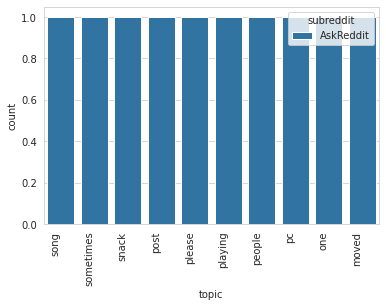

In [166]:
df_hot = pd.read_csv(path+'hot_topics', sep=',|\t', header=None, names= ['count','subreddit','topic'],engine='python')
df_hot['count'] = 1e6 - df_hot['count']
display(df_hot)
df_hot.sort_values(['subreddit','count'], ascending=[True,False], inplace=True)
g = sns.barplot(data=df_hot, x='topic', y='count', hue='subreddit')
g.set_xticklabels(g.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right');

,count,user,topic
0,2.0,subredditreports,xx
1,1.0,subredditreports,xxxx
2,1.0,subredditreports,xxx
3,1.0,subredditreports,man
4,1.0,subredditreports,1ml
5,1.0,AutoModerator,post
6,1.0,AutoModerator,please


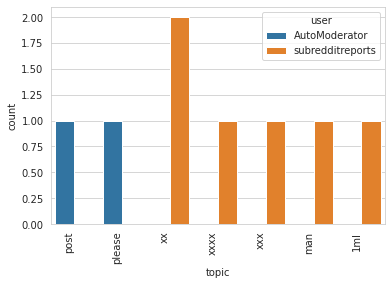

In [167]:
df_hot = pd.read_csv(path+'hot_topics_user', sep=',|\t', header=None, names= ['count','user','topic'],engine='python')
df_hot['count'] = 1e6 - df_hot['count']
display(df_hot)
df_hot.sort_values(['user','count'], ascending=[True,False], inplace=True)
g = sns.barplot(data=df_hot, x='topic', y='count', hue='user')
g.set_xticklabels(g.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right');

# 3. Controversial comments
Ummm, we tried to use another rule for controversiality since most of the comments has 0 controverrsiality. This is most probably because the retrieval time is quite close to the creation time (1 month or so), so these comments in the dataset are quite new and didn't have the time to make impact or gain comments from the users. We used this formula ${cont. = score/(upvotes+downvotes)}$. Then we sum the controversity score accross each subreddit and innerjoin with the count table to get an average controversialty score. 
This is more a comparison between how controversial a subreddit is (instead of a post or a topic) and how big (more comments) it is. So basically, it's (sum of conv score across comments / count of comments) vs count of comments.


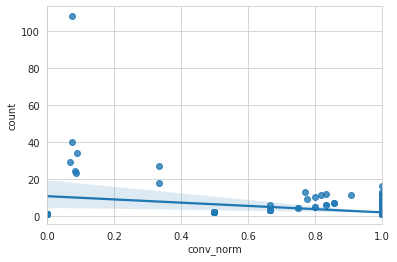

In [168]:
df_sub = pd.read_csv(path+'subreddit_count', sep='\t', header=None, names= ['subreddit','count'])
df_con = pd.read_csv(path+'controv', sep='\t', header=None, names= ['subreddit','conv'])
df = pd.merge(df_con,df_sub, on='subreddit').drop_duplicates('subreddit').sort_values(['conv','count'])
df['conv_norm'] = df.conv/df['count']
sns.regplot(data=df, x='conv_norm', y='count');

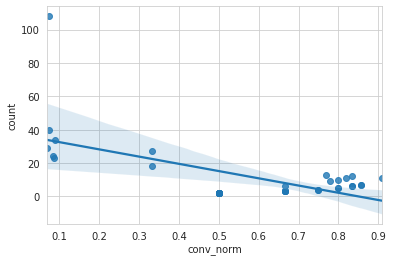

In [169]:
#now let's drop the elements with 0 or 1 normalized since it indicates total upvote or total downvote which shows no controversiality
df = df[(df.conv_norm!=0) & (df.conv_norm!=1)]
sns.regplot(data=df, x='conv_norm', y='count');

We can see here there is a negative correlation between the average conversiality score of the subreddit and the popularity (number of monthly comments) of the subreddit.

# 4. Topics upvoted the most.
We tried to take another approach regarding a topics popularity. Instead of summing out the words within a comment and come up with one topic, we will count the words within the whole file and find out the most common word within the file that has the most upvotes as well. That should create a hell of a mess so we narrowed down the output of the mappers to only the words that occured twice or more within the comment to be outputted. We ignored the downvotes since most of the comments has no downvotes or insignificant compared to upvotes.

NB: Some words are not included in the stoplist and are meaningless, there is no way but to be handled manually forr now. You know subreddit is full of unexpected shit.

,topic,ups
28,bad,348
216,unpopular,277
113,like,86
138,new,83
89,going,55
150,opinions,48
81,first,48
173,really,28
75,entrepreneur,25
56,cup,24


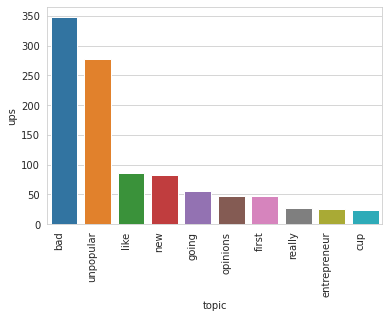

In [170]:
df_up = pd.read_csv(path+'max_topics_upvotes', sep='\t', header=None, names= ['topic', 'ups'], error_bad_lines=False)
df_up.sort_values('ups', ascending=False, inplace=True)
df_up = df_up.iloc[:10]
display(df_up)
g = sns.barplot(data=df_up, x='topic', y = 'ups')
g.set_xticklabels(g.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right');

# 5. What time do people reddit the most?
It would be useful to get info about the active hours for each subreddit. Maybe there is a unique pattern for each subrreddit. Mybe it's a common trend across reddit subtopics collectively.
We divided the day into 8 equal subintervals each of 3 hours, starting from 00:00 AM to 03:00 AM for example, UTC time.
We considered only the top 3 subreddits.

NB: The data here is biased since we took the first 1400 line only which explains why all the data fall in the first column.


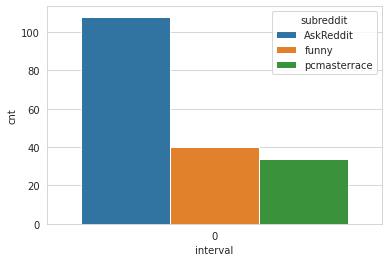

In [171]:
df_time = pd.read_csv(path+'what_time', sep=',|\t', header=None, names= ['subreddit', 'interval', 'cnt'], engine='python')
df_time.sort_values(['subreddit','interval'], inplace=True)
g = sns.barplot(data=df_time, x='interval', y='cnt', hue='subreddit')